In [1]:
import gc
import time
import numpy as np
from plotly import express as px

import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer

/home/ian/miniconda3/envs/llm-activation-control/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def start_memory_tracking():
    """Initialize GPU memory tracking."""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    else:
        print("This notebook is intended for CUDA GPUs but CUDA is not available.")


def print_memory_usage():
    max_gpu_memory = torch.cuda.max_memory_allocated() / (
        1024**3
    )  # Convert bytes to GB
    print(f"Maximum GPU memory allocated: {max_gpu_memory:.1f} GB")


def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(3)  # some buffer time to allow memory to clear
    torch.cuda.reset_peak_memory_stats()
    max_memory_allocated = torch.cuda.max_memory_allocated(device) / (1024**3)
    print(f"Maximum GPU memory allocated: {max_memory_allocated:.1f} GB")

In [3]:
import os
import psutil
from threading import Thread


def monitor_memory_usage_in_gb(func):
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())

        # Measure the baseline memory usage before running the function
        baseline_mem = process.memory_info().rss / 1024**3  # in GB

        # Start monitoring memory in a separate thread
        mem_usage = []
        done = False

        def monitor_memory():
            while not done:
                mem_usage.append(process.memory_info().rss / 1024**3)  # Convert to GB
                time.sleep(0.1)

        t = Thread(target=monitor_memory)
        t.start()

        # Run the function
        result = func(*args, **kwargs)

        # Stop monitoring
        done = True
        t.join()

        peak_mem_usage_gb = max(mem_usage) - baseline_mem
        print(f"-> Maximum CPU memory allocated: {peak_memory_used:.1f} GB")

        return result

    return wrapper

In [4]:
@monitor_memory_usage_in_gb
def load_model(model_name, device):
    config = AutoConfig.from_pretrained(model_name)

    with torch.device("meta"):
        model = AutoModelForCausalLM.from_config(config)

    model.load_state_dict(
        torch.load("model.pth", map_location=device, weights_only=True, mmap=True),
        assign=True,
    )

    return model

In [6]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
device = "cuda:6"

model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [01:35<00:00, 23.83s/it]


In [7]:
model.model.layers[0]

Qwen2DecoderLayer(
  (self_attn): Qwen2SdpaAttention(
    (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
    (k_proj): Linear(in_features=3584, out_features=512, bias=True)
    (v_proj): Linear(in_features=3584, out_features=512, bias=True)
    (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
  (mlp): Qwen2MLP(
    (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
    (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
    (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
  (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
)

In [7]:
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES

if model_name not in OFFICIAL_MODEL_NAMES:
    OFFICIAL_MODEL_NAMES.append(model_name)

hooked_model = HookedTransformer.from_pretrained_no_processing(
    model_name,
    device=device,
    # dtype=torch.bfloat16,
    default_padding_side="left",
    # bf16=True
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Loaded pretrained model Qwen/Qwen2.5-7B-Instruct into HookedTransformer


In [8]:
dir(hooked_model.blocks[0].attn.b_Q)
torch.allclose(
    hooked_model.blocks[0].attn.b_Q.data.view(-1),
    model.model.layers[0].self_attn.q_proj.bias.data,
)

model.model.layers[0].self_attn.o_proj.weight.data.shape
print(dir(hooked_model.blocks[0].attn))
print(hooked_model.blocks[0].attn.W_O.shape)
print(hooked_model.blocks[0].mlp.W_out.shape)
dir(model.model.layers[0].mlp)
# model.model.layers[0].self_attn.head_dim

['IGNORE', 'OV', 'QK', 'T_destination', 'W_K', 'W_O', 'W_Q', 'W_V', '_W_K', '_W_V', '__abstractmethods__', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_apply', '_b_K', '_b_V', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_is_hf_initialized',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_no

## Mean scalar projection between pairs of layer output matrices

This tries to look at the following:

- If the output matrices store features as their row/column vectors, then let's see how
  much overlap there is each pair of layers (i.e. do they contain some common features).


In [9]:
import numpy as np

num_layers = len(hooked_model.blocks) * 2

layer_names = sum([[f"{i}-attn", f"{i}-mlp"] for i in range(num_layers // 2)], [])

# mean = [[0] * num_layers for _ in range(num_layers)]
# std = [[0] * num_layers for _ in range(num_layers)]
pair_wise = {}

num_layers = 10
for i in range(num_layers):
    if i % 2 == 0:
        A = hooked_model.blocks[i // 2].attn.W_O
    else:
        continue
        A = hooked_model.blocks[i // 2].mlp.W_out
    A_norm = A / A.norm(dim=-1, keepdim=True)

    for j in range(i, num_layers):
        print(f"{i}: {layer_names[i]}, {j}: {layer_names[j]}")

        if j % 2 == 0:
            B = hooked_model.blocks[j // 2].attn.W_O
        else:
            continue
            B = hooked_model.blocks[j // 2].mlp.W_out
        B_norm = B / B.norm(dim=-1, keepdim=True)

        m = A_norm.view(-1, A.shape[-1]) @ B_norm.view(B.shape[-1], -1)

        m = m.detach().cpu().numpy()

        pair_wise[(layer_names[i], layer_names[j])] = m
        # mean[i][j] = m.mean()
        # std[i][j] = m.std()

0: 0-attn, 0: 0-attn
0: 0-attn, 1: 0-mlp
0: 0-attn, 2: 1-attn
0: 0-attn, 3: 1-mlp
0: 0-attn, 4: 2-attn


0: 0-attn, 5: 2-mlp
0: 0-attn, 6: 3-attn
0: 0-attn, 7: 3-mlp
0: 0-attn, 8: 4-attn
0: 0-attn, 9: 4-mlp
2: 1-attn, 2: 1-attn
2: 1-attn, 3: 1-mlp
2: 1-attn, 4: 2-attn
2: 1-attn, 5: 2-mlp
2: 1-attn, 6: 3-attn
2: 1-attn, 7: 3-mlp
2: 1-attn, 8: 4-attn
2: 1-attn, 9: 4-mlp
4: 2-attn, 4: 2-attn
4: 2-attn, 5: 2-mlp
4: 2-attn, 6: 3-attn
4: 2-attn, 7: 3-mlp
4: 2-attn, 8: 4-attn
4: 2-attn, 9: 4-mlp
6: 3-attn, 6: 3-attn
6: 3-attn, 7: 3-mlp
6: 3-attn, 8: 4-attn
6: 3-attn, 9: 4-mlp
8: 4-attn, 8: 4-attn
8: 4-attn, 9: 4-mlp


In [10]:
# mean = np.array(mean)
# std = np.array(std)
# np.save(f"{model_name.split('/')[-1]}_mean.npy", mean)
# np.save(f"{model_name.split('/')[-1]}_std.npy", std)
# np.save(f"{model_name.split('/')[-1]}_pair_wise_dict.npy", pair_wise)

(3584,)
(array([False,  True]), array([3414,  170]))


<BarContainer object of 100 artists>

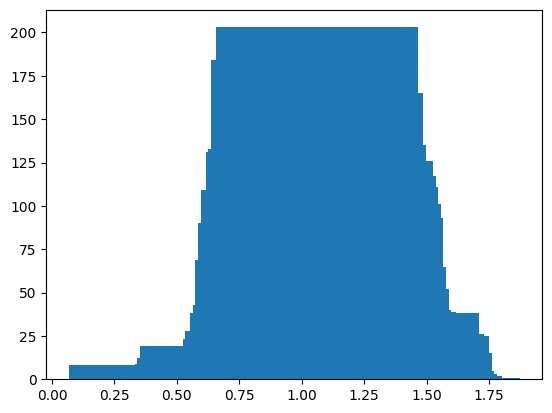

In [38]:
W = hooked_model.blocks[24].attn.W_O
W = W.reshape(-1, W.shape[-1])
# W = W / W.norm(dim=-1, keepdim=True)
W = W.detach().cpu().numpy()
# C = np.sqrt((W**2).sum(axis=-1))
print(C.shape)
print(np.unique((C > -0.9) * (C < 0.9), return_counts=True))
counts, bins = np.histogram(C.flatten(), bins=100)
plt.bar(bins[:-1], counts)
# np.sum(C)

0.18169978
-0.16541654


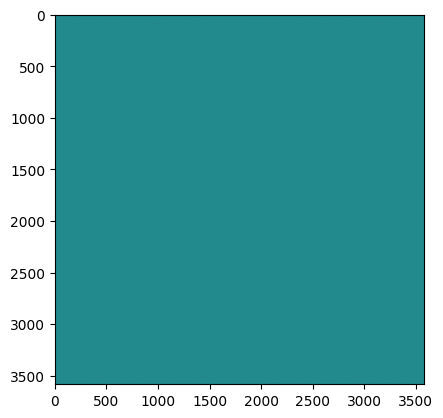

In [18]:
import plotly.express as px
import matplotlib.pyplot as plt

# for i in range(num_layers // 2):
i = 4
A = pair_wise[f"{i}-attn", f"{i}-attn"]
print(A.max())
print(A.min())
plt.imshow(A)
plt.show()

In [5]:
mean = np.load(f"{model_name.split('/')[-1]}_mean.npy")
std = np.load(f"{model_name.split('/')[-1]}_std.npy")

In [ ]:
import plotly.express as px

num_layers = mean.shape[0]
layer_names = sum([[f"{i}-pre", f"{i}=mid"] for i in range(num_layers // 2)], [])

x_axis = sum([[layer_names[i]] * num_layers for i in range(num_layers)], [])
y_axis = layer_names * num_layers
fig = px.scatter_3d(x=x_axis, y=y_axis, z=mean.flatten(), color=std.flatten())
fig.show()

In [31]:
config = AutoConfig.from_pretrained("Qwen/Qwen-1_8B-chat", trust_remote_code=True)

## Transforming column vectors of model weights to standard bases


In [ ]:
from transformers import 

ImportError: cannot import name 'QWenLMHeadModel' from 'transformers' (/home/ian/miniconda3/envs/llm-activation-control/lib/python3.12/site-packages/transformers/__init__.py)